## Blob Method 
This notebook works inside the QuaKe/examples folder.
- Finding the hits corresponding to the track endpoints (blob centres) with a BFS (Breadth First Search) method.
- Collecting the blob energies within a radius r
- The most energetic blob is labeled as blob1, the other as blob2, with energies respectively en_1 and e_2
- en_1 and e_2 are treated as input features for a SVM or a Neyman-Pearson based classifier.

In [17]:
from quake.models.attention.attention_dataloading import read_data
from quake.utils.utils import load_runcard
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from quake.models.blob.blob_detection import (
    get_blob_energies,
    distance_matrix,
    find_main_trajectory,
    train_blobs,
)

In [18]:
# Loading dataset and runcard options. Assuming an 'output' folder has been created with 'quake datagen'
data_folder = Path("../../output/data")
train_folder = Path("../../output/models/attention")
setup = load_runcard(data_folder.parent / "cards/runcard.yaml")
setup["seed"] = 42  # may be set as we please

In [19]:
binwidths = np.array(setup["detector"]["resolution"])

In [20]:
# Preparing the train, validation and test
train_generator, val_generator, test_generator = read_data(
    data_folder, train_folder, setup
)

[INFO] (quake.attention) Saving splitting maps in folder ../../output/models/attention
[INFO] (quake.attention) Train dataset balancing: 125499 training points, of which 50.06% positives
[INFO] (quake.attention) Validation dataset balancing: 26893 training points, of which 49.46% positives
[INFO] (quake.attention) Test dataset balancing: 26893 training points, of which 50.37% positives


### Example: detecting blobs in a single track

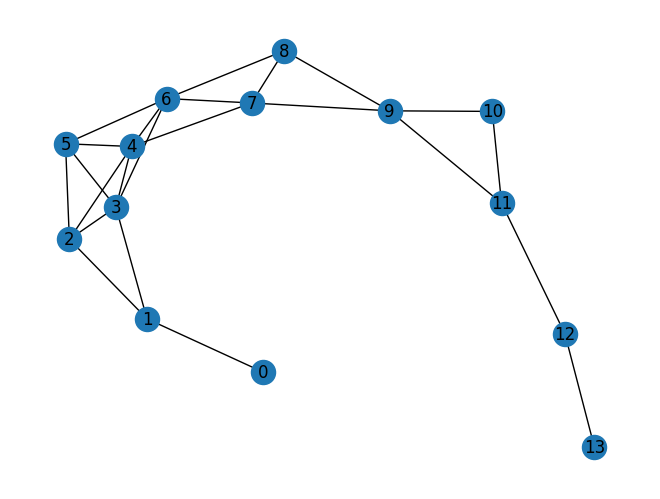

In [21]:
# Creating the graph associated with the first training event
edges = distance_matrix(train_generator.inputs[5], setup, euclid=False)
graph = nx.from_numpy_matrix(edges)
nx.draw(graph, with_labels=True)

In [22]:
# Detecting blob location with a BFS algorithm
blob1, blob2 = find_main_trajectory(graph)
print("The estimated track endpoints are in nodes", blob1, "and", blob2)

The estimated track endpoints are in nodes 0 and 13


### Measuring blob energies in the whole dataset

In [23]:
# Extracting blob energies from point-cloud tracks
training_en_1, training_en_2 = get_blob_energies(train_generator.inputs, setup)
val_en_1, val_en_2 = get_blob_energies(val_generator.inputs, setup)
test_en_1, test_en_2 = get_blob_energies(test_generator.inputs, setup)

# Labels
training_labels = train_generator.targets
val_labels = val_generator.targets
test_labels = test_generator.targets

As expected, $\beta\beta$ events have blobs with similar energies, and datapoints arrange closer to the bisector. For $\beta$ events, only one is a proper blob (marking the single-electron stopping-point position), hence one blob candidate has more energy than the other one.

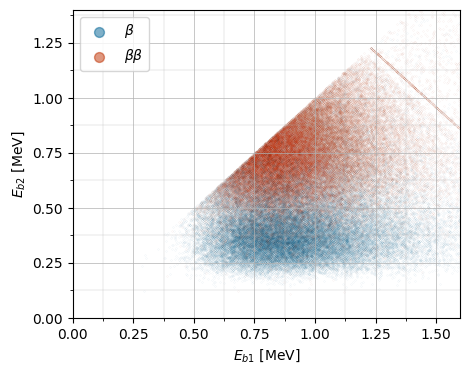

In [24]:
n = train_generator.nb_hits_array
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)

major_ticks = np.arange(0, 1.8, 0.25)
minor_ticks = np.arange(0, 1.8, 0.125)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.set_xlim([0, 1.6])
ax.set_ylim([0, 1.4])

ax.grid(which="major", linewidth=0.5)
ax.grid(which="minor", linewidth=0.2)

ax.scatter(
    training_en_1[np.logical_and(training_labels == 0, n > 9)],
    training_en_2[np.logical_and(training_labels == 0, n > 9)],
    s=0.002,
    c="#006394",
    label=r"$\beta$",
    alpha=0.5,
)
ax.scatter(
    training_en_1[np.logical_and(training_labels == 1, n > 9)],
    training_en_2[np.logical_and(training_labels == 1, n > 9)],
    s=0.002,
    c="#bf3000",
    label=r"$\beta\beta$",
    alpha=0.5,
)
ax.set_xlabel(r"$E_{b1}$ [MeV]")
ax.set_ylabel(r"$E_{b2}$ [MeV]")
lgnd = ax.legend(fontsize=10)


# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
# plt.savefig("blob_distribution.pdf", bbox_inches="tight")

Text(0.2, 1.35, '$\\beta\\beta$ class')

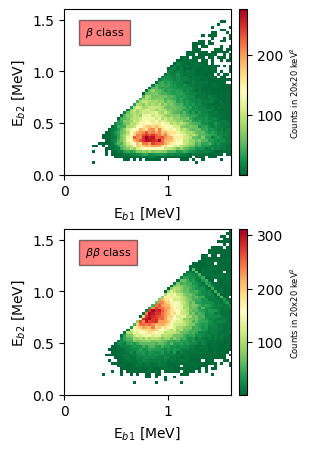

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3, 4.4), constrained_layout=True)
# fig.tight_layout(pad  = 1.5)
h1 = axes[0].hist2d(
    training_en_1[np.logical_and(training_labels == 0, n > 8)],
    training_en_2[np.logical_and(training_labels == 0, n > 8)],
    bins=[60, 60],
    range=[[0, 1.8], [0, 1.6]],
    cmin=1,
    cmap="RdYlGn_r",
)[-1]
axes[0].set_xlabel(r"E${}_{b1}$ [MeV]")
axes[0].set_ylabel(r"E${}_{b2}$ [MeV]")
axes[0].set_ylim([0, 1.6])
axes[0].set_xlim([0, 1.6])

h2 = axes[1].hist2d(
    training_en_1[np.logical_and(training_labels == 1, n > 8)],
    training_en_2[np.logical_and(training_labels == 1, n > 8)],
    bins=[60, 60],
    range=[[0, 1.8], [0, 1.6]],
    cmin=1,
    cmap="RdYlGn_r",
)[-1]
axes[1].set_xlabel(r"E${}_{b1}$ [MeV]")
axes[1].set_ylabel(r"E${}_{b2}$ [MeV]")
axes[1].set_ylim([0, 1.6])
axes[1].set_xlim([0, 1.6])


cbar1 = fig.colorbar(h1, ax=axes[0])
cbar2 = fig.colorbar(h2, ax=axes[1], label=r"Counts in 20x20 keV${}^2$")
cbar1.set_label(r"Counts in 20x20 keV${}^2$", fontsize=6)
cbar2.set_label(r"Counts in 20x20 keV${}^2$", fontsize=6)
axes[0].text(
    0.2, 1.35, r"$\beta$ class", fontsize=8, bbox=dict(facecolor="red", alpha=0.5)
)
axes[1].text(
    0.2, 1.35, r"$\beta\beta$ class", fontsize=8, bbox=dict(facecolor="red", alpha=0.5)
)
# plt.savefig("blob_histogram.svg", bbox_inches = "tight")

In [ ]:
dddd

### Training a SVM for classification

In [ ]:
from sklearn.svm import SVC

training_data = np.vstack([training_en_1, training_en_2]).T
val_data = np.vstack([val_en_1, val_en_2]).T
model = train_blobs(
    training_data[:5000], training_labels[:5000], "svm"
)  # Using only 5e3 training events for computational tradeoff
model.score(val_data, val_labels)
print("Model accuracy is ", model.score(val_data, val_labels))

[INFO] (quake.blob) Predicting classes with SVM


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .............................................C=0.01; total time=   0.8s
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ................................................C=1; total time=   0.5s
[CV] END ................................................C=1; total time=   0.5s
[CV] END ................................................C=1; total time=   0.6s
[CV] END ...............................................C=10; total time=   0.6s
[CV] END ...............................................C=10; total time=   0.7s
[CV] END ........................................

[INFO] (quake.blob) {'C': 0.1}


Model accuracy is  0.8436267579432993


### Training a NP model for classification

In [ ]:
training_data = np.vstack([training_en_1, training_en_2]).T
val_data = np.vstack([val_en_1, val_en_2]).T
model = train_blobs(training_data, training_labels, "neyman_pearson")
print("Model accuracy is ", model.score(val_data, val_labels))

[INFO] (quake.blob) Predicting classes with Neyman-Pearson lemma


Model accuracy is  0.8429570652578317
